In [1]:
import numpy as np
import re
import random

import tensorflow as tf
import sklearn as sk

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
#print('Number of Texts: ', Dataset.size)
#print('Number of 2007 Smoking Challenge texts: ', Dataset.number_of(challenge='2007 Smoking Challenge'))
#print('Number of 2008 ObesityChallenge texts: ', Dataset.number_of(challenge='2008 Obesity Challenge'))
#print('Number of 2009 Medication Challenge texts: ', Dataset.number_of(challenge='2009 Medication Challenge'))
#print('Number of 2010 Relations Challenge texts: ', Dataset.number_of(challenge='2010 Relations Challenge'))
#print('Number of 2011 Coreference Challenge texts: ', Dataset.number_of(challenge='2011 Coreference Challenge'))
#print('Number of 2012 Temporal Relations Challenge texts: ', Dataset.number_of(challenge='2012 Temporal Relations Challenge'))
#print('Number of Train Texts: ', Dataset.number_of(stage='train'))
#print('Number of Test Texts: ', Dataset.number_of(stage='test'))
#print('Number of Labeled Texts: ', Dataset.number_of(labelled='yes'))
#print('Number of Initially Labeled Texts: ', Dataset.number_of(labelled='yes', label_type='train'))
#print('Number of Competitor Labeled Texts Texts: ', Dataset.number_of(labelled='yes', label_type='test'))

In [4]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [5]:
from gensim.models import Word2Vec

#sentences = fn.load_sentences('sent')
#model = Word2Vec(sentences, min_count=1, size=100)

model = Word2Vec.load('W2V')

C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [6]:
#model.most_similar("prozac", topn=10)

# Visualisation

In [7]:
#fn.visualise(model, sentences, [target_dict['medications']], 1000, 'Medications in top 1000 words')

In [8]:
#print_set = []
#for case in Dataset.get_DS(labelled='yes').data:
#    for term in re.finditer(r'm="[^|]+\|', case.raw_labels):
#        print_set.append(term.group()[:-1])
#print(*print_set, sep='\n')

# Naive Test 

Train set size: 6634 	Percentage of labels: 0.099940
Test set size: 1326 	Percentage of labels: 0.500000
Target: medications 	Repetitions: True


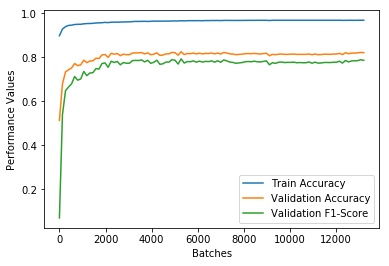

FInal Accuracies: tr: 0.969099, va: 0.821267
Test F1-Score: 0.786679

Train set size: 6634 	Percentage of labels: 0.099940
Test set size: 1326 	Percentage of labels: 0.500000
Target: medications 	Repetitions: False


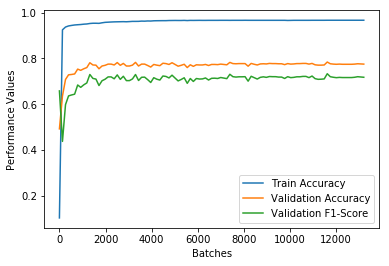

FInal Accuracies: tr: 0.966838, va: 0.775264
Test F1-Score: 0.717803



In [9]:
for target in ['medications']:
    for reps in [True, False]:
        target_size = len(target_dict[target])
        sets = fn.get_naive_traintest(model, target_dict[target], target_size * 5, target_size, 10, 50, reps, reps)
        sets = {'train_set': sets[0], 'train_labels': sets[1], 'validation_set': sets[2], 'validation_labels': sets[3], 'test_set': sets[2], 'test_labels': sets[3]}
        print("Target: %s \tRepetitions: %s" % (target, reps))
        NN = FF_Model()
        NN.build_graph()
        NN.train(sets, epochs=100, report_percentage=1)

# HyperParameter Scan